# arrayのソート
## NumPyのFastソート：`np.sort`と`np.argsort`
デフォルトで`np.sort`は`O[NlogN]`のクイックソートを使用する。

In [1]:
import numpy as np

In [2]:
x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

その場でソートしたい場合は、arrayの`sort`メソッドとして使用することも可能。

In [3]:
x.sort()
print(x)

[1 2 3 4 5]


似たような関数に`argsort`がある。それはソートした要素のインデックスを代わりに返す。

In [4]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


In [5]:
x[i]

array([1, 2, 3, 4, 5])

### 行や列に沿ったソート

In [6]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [7]:
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])

In [8]:
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])

## 部分ソート：パーティショニング
array全体をソートすることに興味はないが、単純にk個の最も小さい値のarrayを探したいような場合がある。NumPyは`np.partition`関数でこれを提供する。`np.partition`はarrayと数値Kを受け取る。その結果として、最も小さいK個の値を左側部分に、残りの値を右側部分に任意の順序で並べた新しいarrayを返す。

In [9]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([2, 1, 3, 4, 6, 5, 7])

In [10]:
X

array([[6, 3, 7, 4, 6, 9],
       [2, 6, 7, 4, 3, 7],
       [7, 2, 5, 4, 1, 7],
       [5, 1, 4, 0, 9, 5]])

In [11]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])

## 例：K個の近傍点

In [12]:
X = rand.rand(10, 2)

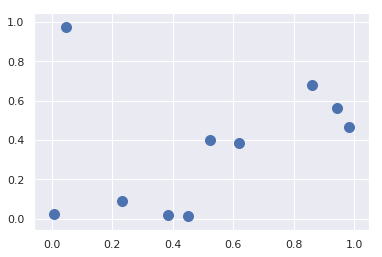

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
plt.scatter(X[:, 0], X[:, 1], s=100);

2点間の座標の差の和の2乗の平方根が距離となるため、ブロードキャストとアグリゲーションを利用して計算する。

In [14]:
print(X[np.newaxis, :, :].shape)
print(X[:, np.newaxis, :].shape)

(1, 10, 2)
(10, 1, 2)


In [15]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)

NumPyになれていないと上記の処理は頭が追いつかない。そこで、以下の通り処理を分解する。

In [16]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [17]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [18]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

正しく計算できていれば、対角成分は0となる。

In [19]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

各点までの距離が計算できているため、これを`argsort`すれば、距離が近い点までの順で並べられる。ただし、自分自身の点も含んでいるため、一番近い点は自分自身となっている。

In [20]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 3 9 7 1 4 2 5 6 8]
 [1 4 7 9 3 6 8 5 0 2]
 [2 1 4 6 3 0 8 9 7 5]
 [3 9 7 0 1 4 5 8 6 2]
 [4 1 8 5 6 7 9 3 0 2]
 [5 8 6 4 1 7 9 3 2 0]
 [6 8 5 4 1 7 9 3 2 0]
 [7 9 3 1 4 0 5 8 6 2]
 [8 5 6 4 1 7 9 3 2 0]
 [9 7 3 0 1 4 5 8 6 2]]


上記ではフルソートを利用したが、この場合、単純に最も近いk個の近傍点のみが興味の対象であるため、必要となるのは最も近いk+1個の近傍点の部分であるため、`np.argpartition`でその部分を取得できる。

In [21]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)
print(nearest_partition)

[[3 0 9 7 1 4 2 5 8 6]
 [1 4 7 9 3 5 6 2 8 0]
 [2 1 4 6 3 0 5 7 8 9]
 [3 9 7 0 1 5 6 2 8 4]
 [1 8 4 5 7 6 9 3 2 0]
 [5 8 6 4 1 7 9 3 2 0]
 [6 8 5 4 1 7 9 3 2 0]
 [7 9 3 1 4 5 6 2 8 0]
 [8 5 6 4 1 7 9 3 2 0]
 [3 9 7 0 1 5 6 2 8 4]]


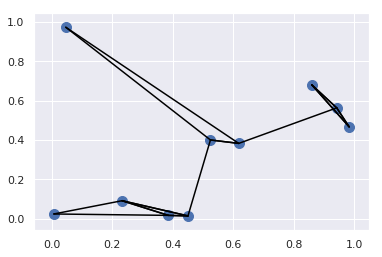

In [22]:
plt.scatter(X[:, 0], X[:, 1], s=100)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')